# Data Cleaning and Preprocessing 

The process of data cleaning and processing is included in the source codes in cleaning_and_eda. The preprocess added the following new features: 

- Goal: given shoot was a goal. 
- Header: control or shoot balls using head. 
- Counter Attack: a counter attack. 
- Blocked: shoot was blocked. 
- Right Foot: using right foot. 
- First Half: was in first half of the match. 
- X: X coordinate of the shoot. 
- Y: Y coordinate of the shoot. 
- C: distance in Y direction from the goal. 
- strong foot: Given shoot was executed by the player's strong foot or not.  
- Distance: distance of the shoot. 
- angle_degrees: angle of the shoot converted to degrees. 


In [50]:
# Import necessary modules 
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.patheffects as path_effects

from mplsoccer.pitch import Pitch, VerticalPitch
from cleaning_and_eda import * 

In [2]:
# All goals with added features
dataset = process_dataset("data")

# All events
event = pd.read_json("data/event/events_England.json")
for i in os.listdir("data/event"): 
    if i != "events_England.json": 
        evt = pd.read_json("data/event/" + i)
        event = pd.concat([evt, event], ignore_index = True) 

# All players
players = read_process_players("data") 

# All teams 
teams = pd.read_json("data/teams.json").rename({"wyId": "teamId"}, axis = 1) 

# EDA 

Exploratory Data Analysis to understand the basic information about datasets we use. 

**Event dataset**: all events relevent to the movement of the ball in the match. 

In [7]:
event.shape

(3251294, 12)

In [12]:
event["matchId"].nunique()

1941

In [25]:
event.isna().sum()[event.isna().sum() > 0]

Series([], dtype: int64)

There are 3251294 events happened in 1941 different matches, each event belongs to a match ideitnfied by "matchId", every event is represented by a unique "eventId". There are 12 columns in the event dataset. 


There is no missing value in the event dataset.  

**Players dataset**: all players participated in the matches. 

In [20]:
players.shape 

(3603, 13)

In [27]:
players.isna().sum()[players.isna().sum() > 0]

currentTeamId    91
dtype: int64

There are 3603 players in the dataset, each player is represented by a unique "wyId". The players dataset has 13 columns. 

There are 91 missing values in the "currentTeamId" column. It doesn't matter because we will analyze teams in the match level instead of players level.  

**Teams dataset**: add teams participated in the matches. 

In [28]:
teams.shape

(142, 6)

In [29]:
teams.isna().sum()[teams.isna().sum() > 0] 

Series([], dtype: int64)

There are 142 teams in the dataset, each team is represented by a unique "teamId". The teams dataset has 6 columns.

There is no missing value in the teams dataset.  

**Shots dataset**: all events related to shots. 

In [31]:
dataset.shape

(43075, 29)

In [32]:
dataset.isna().sum()[dataset.isna().sum() > 0] 

currentTeamId    332
dtype: int64

There are 43075 shots, each attempted goals is represented by a unique "eventId". The shots dataset has 29 columns. 

There are 332 missing values in the currentTeamId columns, but we don't need to analyze this column so it doesn't matter. 

# Data Analytics

Analyze given datasets, analyze the relationship between goals and other features, and analyze team and player performance in given events. 

**Probability of Goal vs. Distance** 

Text(0, 0.5, 'Goal Probability')

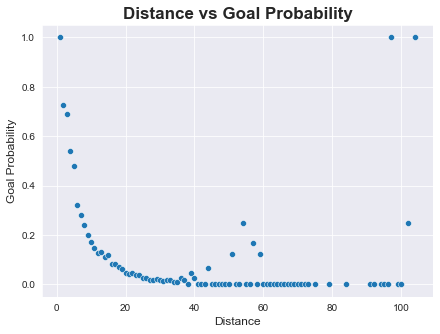

In [38]:
plt.figure(figsize = (7, 5))
dataset["rounded_distance"] = dataset.apply(lambda x: np.round(x["Distance"]), axis = 1) 
sns.scatterplot(x ="rounded_distance", y = "Goal", data = pd.DataFrame(dataset.groupby("rounded_distance").agg("mean")["Goal"]).reset_index())

plt.title('Distance vs Goal Probability', fontsize = 17, weight = "bold")

plt.xlabel("Distance", fontsize = 12)
plt.ylabel("Goal Probability", fontsize = 12)

With the distance increases, the probability of getting a goal decreases. 

**Probability of Goal vs. Angle** 

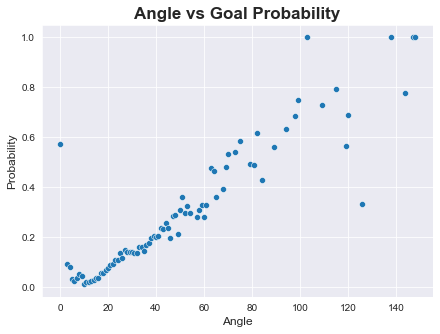

In [40]:
plt.figure(figsize = (7, 5))
dataset["rounded_angle"] = dataset.apply(lambda x: np.round(x["angle_degrees"]), axis = 1) 

sns.scatterplot(x = "rounded_angle", y = "Goal", data = pd.DataFrame(dataset.groupby("rounded_angle").agg("mean")["Goal"]).reset_index())
plt.xlabel('Angle', fontsize = 12)
plt.ylabel('Probability', fontsize = 12)

plt.title('Angle vs Goal Probability', weight = "bold", fontsize = 17)
plt.show()

With angle increases, the probaility of getting a goal increases. 

**Probability of Goal vs. location** 

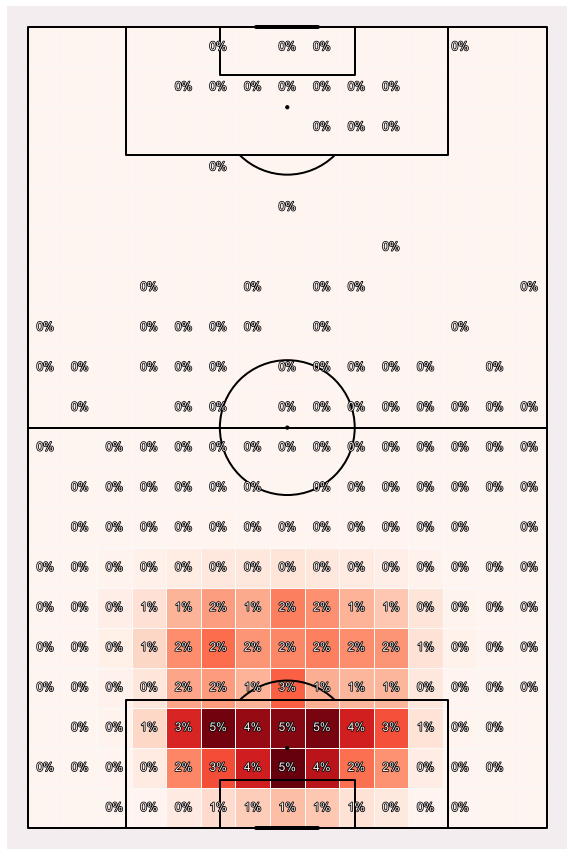

In [52]:
path_eff = [path_effects.Stroke(linewidth = 1.5, foreground = 'black'), path_effects.Normal()]
pitch = VerticalPitch(pitch_color = '#f4edf0', line_color = 'black',line_zorder = 2, stripe = False, pitch_type = 'wyscout')
fig, ax = pitch.draw(figsize = (10, 12))

bin_statistic = pitch.bin_statistic(dataset["X"].astype(float), dataset["Y"].astype(float), statistic = 'count', bins = (20, 15), normalize = True)

pitch.heatmap(bin_statistic, ax = ax, cmap = 'Reds', edgecolor = '#f9f9f9')
labels = pitch.label_heatmap(bin_statistic, color = '#f4edf0', fontsize = 12, ax = ax, ha = 'center', va = 'center', str_format = '{:.0%}', path_effects = path_eff, exclude_zeros = True) 

The locations close to the goal and with relatively high angle have higher chance of getting a goal based on the visualization. 

**Top 10 players** 

Analyze top 10 players based on the number of goals they attemped and the accuracy (the percentage of successful goals) of their attempts. Here, top 10 players are players with highest number of goals, not highest number of attempts. 

In [98]:
top50 = dataset.groupby("wyId").sum().sort_values("Goal", ascending = False)[0:50]
top50_accuracy = dataset.groupby("wyId").mean()["Goal"]
top50_attempts = dataset.groupby("wyId").count()["Goal"]

top50 = players.merge(top50, on = "wyId", how = "right")

top50["Accuracy"] = top50.apply(lambda x: top50_accuracy[x["wyId"]], axis = 1)
top50["Attempts"] = top50.apply(lambda x: top50_attempts[x["wyId"]], axis = 1)
top50[["shortName", "Attempts", "Goal", "Accuracy"]].head()

,shortName,Attempts,Goal,Accuracy
0,Mohamed Salah,141,32,0.226950
1,H. Kane,183,30,0.163934
2,Cristiano Ronaldo,196,28,0.142857
3,L. Messi,154,27,0.175325
4,E. Cavani,107,27,0.252336


Visualize the number of attempts, goals and accuracy of top 10 players. The x axis represents number of goals, the y axis represents the accuracy, the size of the dot represents number of attempts. 

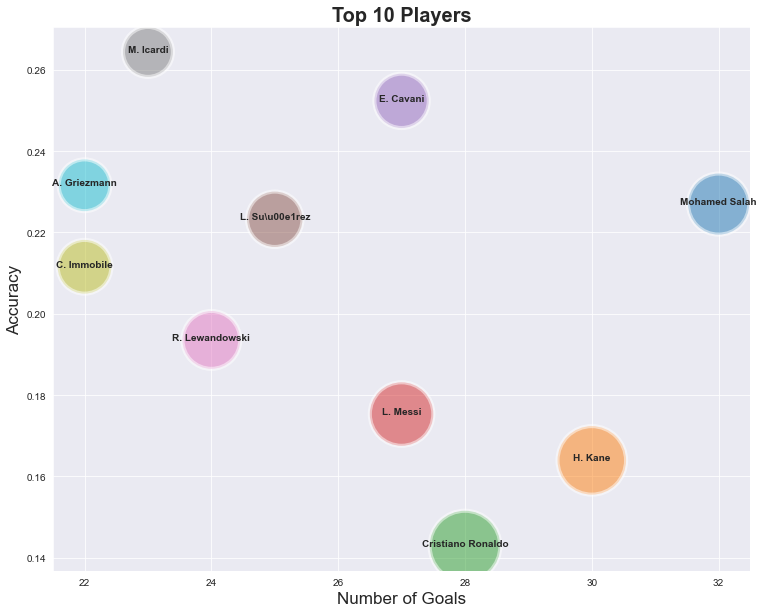

In [108]:
plt.figure(figsize = (12.5, 10))
sns.set_style("darkgrid")
scatterplayers = sns.scatterplot(data = top50[0:10], x = "Goal", y = "Accuracy", size = "Attempts", sizes = (2500, 5000), hue = "shortName", alpha = 0.5, legend = False)

plt.title("Top 10 Players", weight = "bold", fontsize = 20)

plt.xlabel("Number of Goals", fontsize = 17)
plt.ylabel("Accuracy", fontsize = 17)

for i, label in enumerate(top50[0:10]["shortName"]): 
    plt.text(top50[0:10]["Goal"].iloc[i], top50[0:10]["Accuracy"].iloc[i], label, ha = "center", weight = "semibold")

**Top 10 Teams** 

Analyze top 10 teams based on the number of goals they attemped and the accuracy (the percentage of successful goals) of their attempts. Here, top 10 teams are players with highest number of goals, not highest number of attempts.

In [118]:
teams = pd.read_json("data/teams.json")
teams = teams.rename({"wyId": "teamId"}, axis = 1)
teams.head()

,city,name,teamId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alav\u00e9s,696,Deportivo Alav\u00e9s,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


In [121]:
top50 = dataset.groupby("teamId").sum().sort_values("Goal", ascending = False)[0:50]
top50_accuracy = dataset.groupby("teamId").mean()["Goal"]
top50_attempts = dataset.groupby("teamId").count()["Goal"]

top50 = teams.merge(top50, on = "teamId", how = "right")

top50["Accuracy"] = top50.apply(lambda x: top50_accuracy[x["teamId"]], axis = 1)
top50["Attempts"] = top50.apply(lambda x: top50_attempts[x["teamId"]], axis = 1)
top50[["name", "Attempts", "Goal", "Accuracy"]].head()

,name,Attempts,Goal,Accuracy
0,Manchester City,603,94,0.155887
1,PSG,558,90,0.161290
2,Barcelona,502,87,0.173307
3,Bayern M\u00fcnchen,535,83,0.155140
4,Real Madrid,631,81,0.128368


Visualize the number of attempts, goals and accuracy for top 10 teams. The x axis represents number of goals, the y axis represents the accuracy, the size of the dot represents number of attempts.

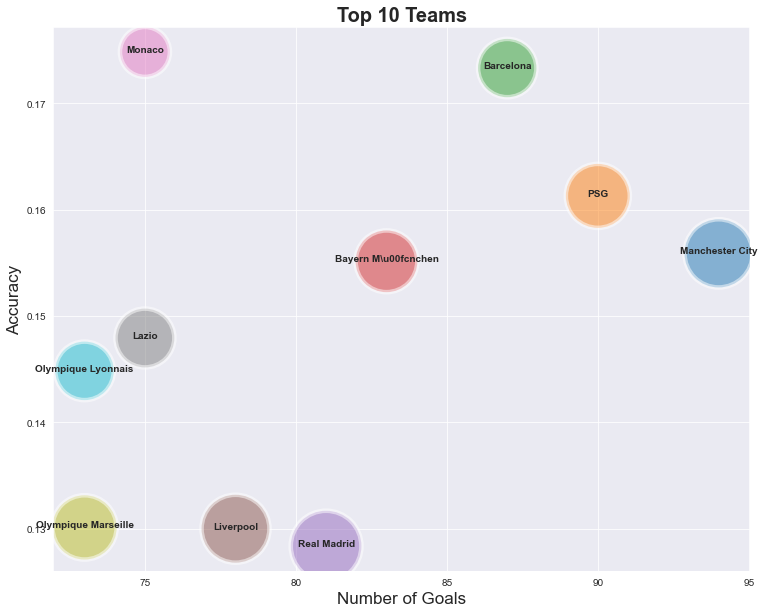

In [123]:
plt.figure(figsize = (12.5, 10))
sns.set_style("darkgrid")
scatterplayers = sns.scatterplot(data = top50[0:10], x = "Goal", y = "Accuracy", size = "Attempts", sizes = (2500, 5000), hue = "name", alpha = 0.5, legend = False)

plt.title("Top 10 Teams", weight = "bold", fontsize = 20)

plt.xlabel("Number of Goals", fontsize = 17)
plt.ylabel("Accuracy", fontsize = 17)

for i, label in enumerate(top50[0:10]["name"]): 
    plt.text(top50[0:10]["Goal"].iloc[i], top50[0:10]["Accuracy"].iloc[i], label, ha = "center", weight = "semibold")